<a href="https://colab.research.google.com/github/zhuodannychen/ai-search-engine/blob/main/AISearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentence-transformers

In [2]:
!pip install faiss-gpu

In [3]:
!pip install --upgrade google-cloud-bigquery

In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [6]:
import pandas as pd
import numpy as np
import os
import time
from tqdm import tqdm
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [7]:
project_id = 'ai-semantic-search'

query = """
SELECT id, title, body, score
FROM `bigquery-public-data.stackoverflow.posts_questions`
WHERE EXTRACT(YEAR FROM creation_date) = 2019
ORDER BY score DESC
LIMIT 100
"""

df = pd.read_gbq(query, project_id=project_id, dialect='standard')

print(df.head())

         id                                              title  \
0  55921442  How to fix "ReferenceError: primordials is not...   
1  58211880  "Uncaught SyntaxError: Cannot use import state...   
2  55840294  How to fix missing dependency warning when usi...   
3  54069253  The useState set method is not reflecting a ch...   
4  57456188  Why is the result of ('b'+'a'+ + 'a' + 'a').to...   

                                                body  score  
0  <p>I have installed Node.js modules by 'npm in...    804  
1  <p>I'm using ArcGIS JSAPI 4.12 and wish to use...    796  
2  <p>With React 16.8.6 (it was good on previous ...    685  
3  <p>I am trying to learn hooks and the <code>us...    667  
4  <p>I was practicing some JavaScript when one o...    644  


In [8]:
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/554 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [9]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['body'],inplace=True)
print(df.shape)

(100, 4)


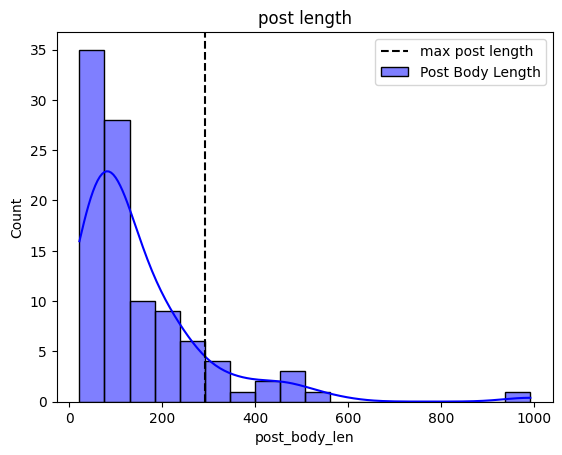

In [10]:
# plot visualization to see post length and one standard deviation cut off
df['post_body_len'] = df['body'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['post_body_len'].mean() + df['post_body_len'].std()).astype(int)
sns.histplot(df['post_body_len'], kde=True, color='b', label='Post Body Length')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max post length')
plt.title('post length'); plt.legend()
plt.show()

In [11]:
import faiss

df['embeddings'] = df['body'].apply(lambda x: model.encode(x))
embeddings = np.array(df['embeddings'].tolist()).astype('float32')
# Create a FAISS index
index = faiss.IndexFlatL2(embeddings.shape[1])  # Using L2 distance for similarity measure
index.add(embeddings)

In [12]:
def fetch_post_info(df_idx):
    info = df.iloc[df_idx]
    meta_info = {
        'title': info['title'],
        'body': info['body'],
        'score': info['score']
    }
    return meta_info

def search(query, index, model, top_k=3):
    start_time = time.time()
    query_embedding = model.encode([query])
    search_results = index.search(query_embedding, top_k) # returns [[distance], [index]]
    end_time = time.time()
    print(f'Total search time: {end_time - start_time:.4f} seconds')

    # print(search_results)
    top_k_idx = np.unique(search_results[1]).tolist()
    top_k_posts = []
    for idx in top_k_idx:
        top_k_posts.append(fetch_post_info(idx))
    return top_k_posts


In [13]:
query = "how to sort integers in python"
search(query, index, model, 5)

Total search time: 0.0719 seconds


[{'title': "Element implicitly has an 'any' type because expression of type 'string' can't be used to index",
  'body': '<p>Trying out TypeScript for a React project and I\'m stuck on this error:</p>\n\n<pre><code>Element implicitly has an \'any\' type because expression of type \'string\' can\'t be used to index type \'{ train_1: boolean; train_2: boolean; train_3: boolean; train_4: boolean; }\'.\n  No index signature with a parameter of type \'string\' was found on type \'{ train_1: boolean; train_2: boolean; train_3: boolean; train_4: boolean; }\'\n</code></pre>\n\n<p>Which appears when I try to filter the array in my component</p>\n\n<pre><code>.filter(({ name }) =&gt; plotOptions[name]);\n</code></pre>\n\n<p>So far I looked at the article "Indexing objects in TypeScript" (<a href="https://dev.to/kingdaro/indexing-objects-in-typescript-1cgi" rel="noreferrer">https://dev.to/kingdaro/indexing-objects-in-typescript-1cgi</a>) since it had a similar error, but I tried to add the index s

In [14]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

tokenizer = T5Tokenizer.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model = T5ForConditionalGeneration.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model.eval()

tokenizer_config.json:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d